<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_resnet_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet solver

It is evident that I don't need to generate the training data three times. Why not generate the training data once, save it in utilis inside a python script called data and import it to each notebook as needed

In [ ]:
pip install pyDOE

In [ ]:
pip install torchdyn

In [ ]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
import time
# from torchdyn.numerics.solvers import SolverTemplate

In [ ]:
# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 261 (delta 23), reused 18 (delta 6), pack-reused 203
Receiving objects: 100% (261/261), 7.04 MiB | 9.46 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [ ]:
cd maestria

/content/maestria


In [ ]:
ls

case_studies/  mc_continuous/       ml_batch/            parameter_estimation/
data/          mc_fb/               ml_fb/               README.md
mc_batch/      mc_fb_optimization/  ml_fb_optimization/  utilis/


In [ ]:
# Import functions from my utilis package
from utilis.functions import create_initial_cond, plot_trajectory, plot_predictions, create_time_span
from utilis.models import fnn_model, inhibition_model_nn
from utilis.solvers import ResnetSolver

1. Create initial conditions for training 
    * 100 initial conditions are created 
    * biomass concentration goes from 0.2 to 10 g/L
    * substrate concentration goes from 0 to 40 g/L
    * product concentrations goes from 0 to 40 g/L

In [ ]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 9.8, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 7.1236,  4.6456, 23.9764],
        [ 1.8365, 25.8761, 35.5724],
        [ 2.8676, 31.0015, 11.6999],
        [ 3.8603, 32.1489, 37.3816],
        [ 2.4974, 29.7049, 29.9660]], dtype=torch.float64)
torch.Size([100, 3])


2. Create initial conditions for validation 
    * 100 initial conditions are created 
    * biomass concentration goes from 1 to 6 g/L
    * substrate concentration goes from 15 to 35 g/L
    * product concentrations goes from 0 to 0 g/L

In [ ]:
# Initial conditions to model validation
x0_validate = create_initial_cond(10, 1, 5, 15, 20, 0, 0)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 3.0221, 30.7357,  0.0000],
        [ 1.6613, 34.2305,  0.0000],
        [ 4.8943, 31.2415,  0.0000],
        [ 3.6257, 22.7563,  0.0000],
        [ 5.7337, 26.9553,  0.0000]], dtype=torch.float64)
torch.Size([10, 3])


3. Create time span for training
    * Each time span is of 1 hour
4. Create time span for validation 
    * Each time span is of 60 hours

In [ ]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

5. Generate training trajectories 
    * Each training trajectory contains two observations. The initial conditions and one step haead

In [ ]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model_nn, x0_train, t_span_train, solver="rk4")

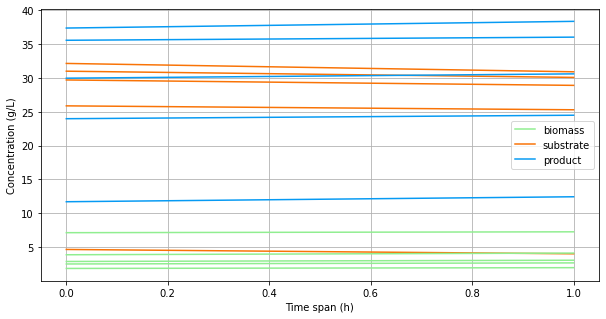

In [ ]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

6. Generate validations trajectories 
    * Each validations trajectory contains sixty one observations. The initial conditions and sixty steps haead

In [ ]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model_nn, x0_validate, t_span_validate, solver="rk4")

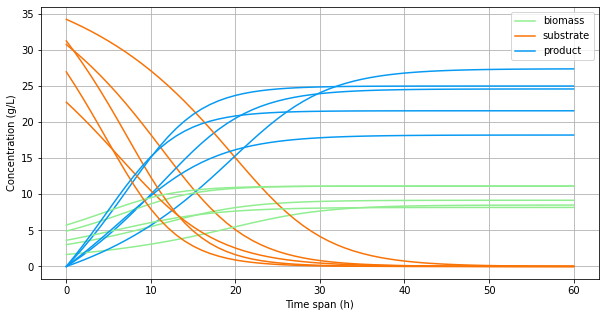

In [ ]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

7. Create the ANN model 
    * The input layer has three input neurons. It is a linear layer and there is no activations functions
    * There exist eight hidden layers each with thirty two neurons and a Sofplus activation function
    * The output layer has thirty two neurons and it is a simple linear function without activation functions 
    * The weights and biases are randomly initialized

In [ ]:
# Create model
net = fnn_model(3, 3, 32, 8)

8. The training algorithm is Adam

In [ ]:
# training algorithm
optimizer = Adam(net.parameters()) 

9. During training:
    * The loss functions is MSE
    * The training occurs for 2000 epochs 

In [ ]:
start_time = time.time()
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver=ResnetSolver()
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    # net.eval()
    # with torch.inference_mode():

    #     # 1. Forward pass
    #     _, x_pred_validate = odeint(
    #         lambda t, x: net(x), 
    #         x0_validate, 
    #         t_span_validate, 
    #         solver=ResnetSolver()
    #     )

    #     # 2. Calculate loss
    #     loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        # print(f"Epoch: {epoch} | Training loss: {loss} | Validate loss: {loss_val}")
        print(f"Epoch: {epoch} | Training loss: {loss}")
end_time = time.time()

  2%|▏         | 49/2000 [00:00<00:07, 256.94it/s]

Epoch: 0 | Training loss: 4.736066776852983
Epoch: 50 | Training loss: 0.10749692136289987


  7%|▋         | 148/2000 [00:00<00:05, 313.99it/s]

Epoch: 100 | Training loss: 0.010674696240643735
Epoch: 150 | Training loss: 0.0015316056832026285


 12%|█▏        | 246/2000 [00:00<00:05, 314.54it/s]

Epoch: 200 | Training loss: 0.0007296794059238516
Epoch: 250 | Training loss: 0.0005028634003341426


 17%|█▋        | 344/2000 [00:01<00:05, 320.33it/s]

Epoch: 300 | Training loss: 0.0004779419037310687
Epoch: 350 | Training loss: 0.0003206196607059183


 22%|██▏       | 446/2000 [00:01<00:04, 330.23it/s]

Epoch: 400 | Training loss: 0.0002718176910389588
Epoch: 450 | Training loss: 0.00022030348089292846


 28%|██▊       | 550/2000 [00:01<00:04, 324.64it/s]

Epoch: 500 | Training loss: 0.00025190474805086204
Epoch: 550 | Training loss: 0.00017628815218521392


 32%|███▏      | 648/2000 [00:02<00:04, 318.52it/s]

Epoch: 600 | Training loss: 0.00015365064884703217
Epoch: 650 | Training loss: 0.000746100776376317


 37%|███▋      | 747/2000 [00:02<00:03, 320.00it/s]

Epoch: 700 | Training loss: 0.0001443416632824826
Epoch: 750 | Training loss: 0.0001278696516115733


 42%|████▎     | 850/2000 [00:02<00:03, 335.06it/s]

Epoch: 800 | Training loss: 0.00011654641416453208
Epoch: 850 | Training loss: 0.000206310225335262


 48%|████▊     | 955/2000 [00:02<00:03, 341.25it/s]

Epoch: 900 | Training loss: 0.0001599698950995777
Epoch: 950 | Training loss: 0.00011686551012690281


 53%|█████▎    | 1058/2000 [00:03<00:02, 326.55it/s]

Epoch: 1000 | Training loss: 0.00010622258777500591
Epoch: 1050 | Training loss: 9.828299519956279e-05


 58%|█████▊    | 1163/2000 [00:03<00:02, 334.21it/s]

Epoch: 1100 | Training loss: 9.161599608635729e-05
Epoch: 1150 | Training loss: 8.576867432810705e-05


 63%|██████▎   | 1264/2000 [00:03<00:02, 323.08it/s]

Epoch: 1200 | Training loss: 0.0005044471171070423
Epoch: 1250 | Training loss: 0.00011616622790449185


 68%|██████▊   | 1364/2000 [00:04<00:01, 323.48it/s]

Epoch: 1300 | Training loss: 0.0001001968010416627
Epoch: 1350 | Training loss: 9.142225489522038e-05


 73%|███████▎  | 1462/2000 [00:04<00:01, 314.50it/s]

Epoch: 1400 | Training loss: 8.48257257353934e-05
Epoch: 1450 | Training loss: 7.935578672779638e-05


 78%|███████▊  | 1558/2000 [00:04<00:01, 300.08it/s]

Epoch: 1500 | Training loss: 7.461241059336985e-05
Epoch: 1550 | Training loss: 7.040079894630354e-05


 83%|████████▎ | 1652/2000 [00:05<00:01, 306.68it/s]

Epoch: 1600 | Training loss: 0.004503103026679769
Epoch: 1650 | Training loss: 0.00014235113001805612


 87%|████████▋ | 1743/2000 [00:05<00:00, 263.63it/s]

Epoch: 1700 | Training loss: 9.852363056634928e-05


 90%|████████▉ | 1796/2000 [00:05<00:00, 251.70it/s]

Epoch: 1750 | Training loss: 8.593939984029125e-05


 92%|█████████▏| 1847/2000 [00:06<00:00, 242.27it/s]

Epoch: 1800 | Training loss: 7.854513291051086e-05


 95%|█████████▍| 1896/2000 [00:06<00:00, 235.60it/s]

Epoch: 1850 | Training loss: 7.300812263445096e-05


 98%|█████████▊| 1950/2000 [00:06<00:00, 251.30it/s]

Epoch: 1900 | Training loss: 6.84165267982074e-05
Epoch: 1950 | Training loss: 6.44224438338701e-05


100%|██████████| 2000/2000 [00:06<00:00, 302.37it/s]


In [ ]:
total_time = end_time - start_time 
print(f"Total time: {total_time:.3f} s")

Total time: 6.627 s


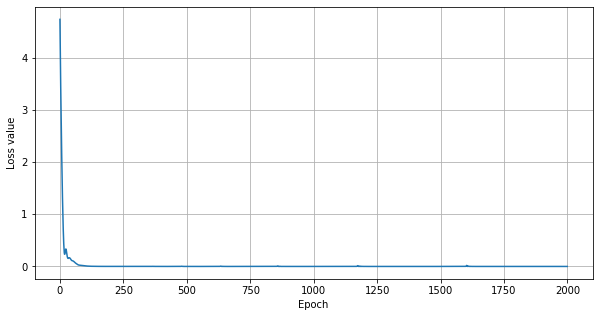

In [ ]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [ ]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver=ResnetSolver()
    ) 

In [ ]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


In [ ]:
mse_loss(x_pred_validate, x_validate) 

tensor(0.3171, dtype=torch.float64)

In [ ]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

Validation 0


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

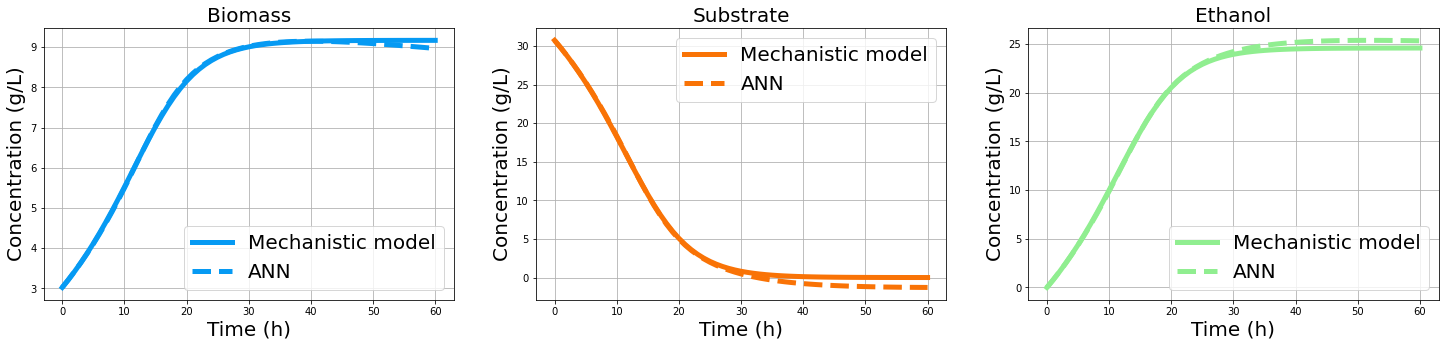

Validation 1


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

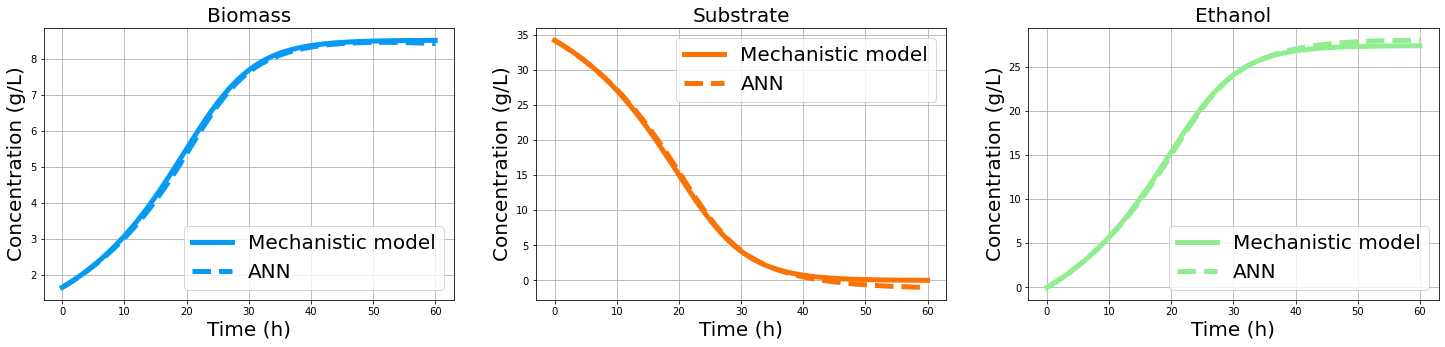

Validation 2


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

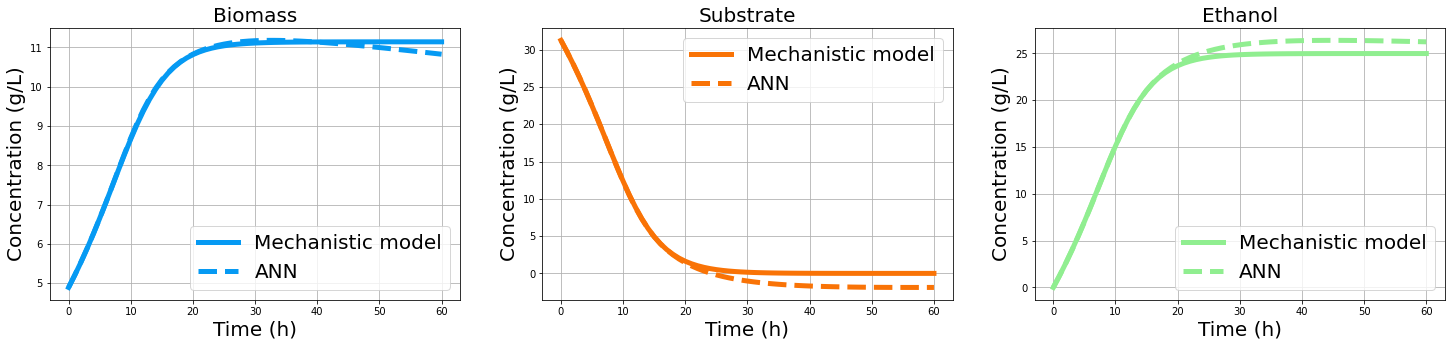

Validation 3


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

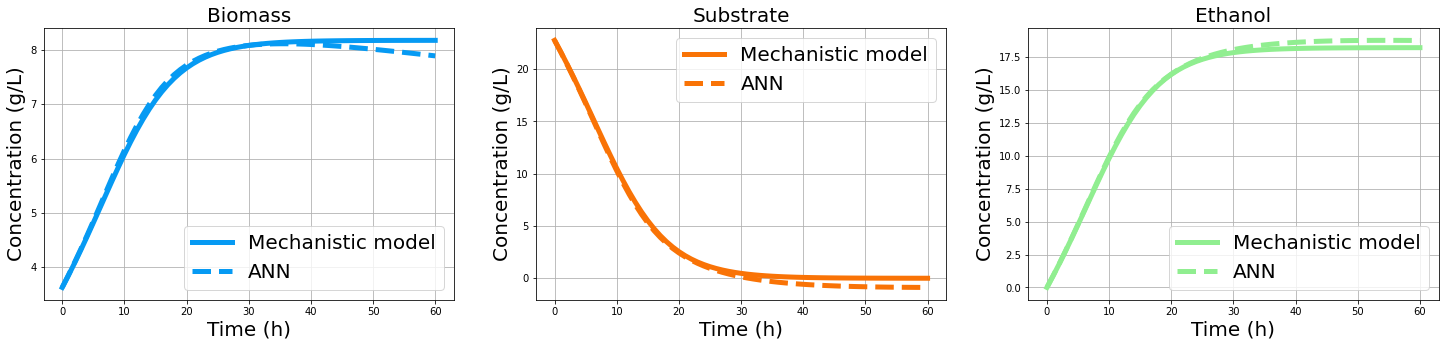

Validation 4


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

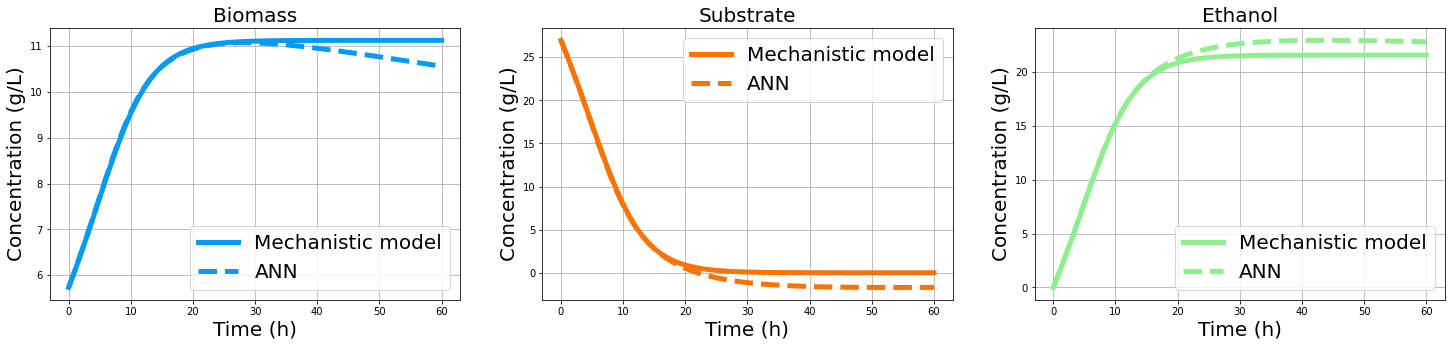

In [ ]:
for i in range(5):
    plot_predictions(t_span_validate, x_validate, x_pred_validate,i)